# Visualizing CNN Layers

In [1]:
from tensorflow.keras.models import load_model
from matplotlib import pyplot
import numpy as np
import pandas as pd
from plotnine import *

## Load model

In [4]:
# Load the model
model = load_model("../../results/model_ensemble/models/weights/cnn_lstm_30-0.41.hdf5")

In [5]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4034, 20)]   0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4034, 32)     640         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 4032, 32)     1920        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 4030, 32)     3200        input_1[0][0]                    
____________________________________________________________________________________________

## Transform CNN models layers into data frames

In [6]:
def get_filter_data(layer_num):
    # retrieve weights from the hidden layer
    filters = model.layers[layer_num].get_weights()
    # reshape layers 
    filters = filters[0]
    
    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    
    # Limits for loop iterations
    num_x, num_y, num_filters = np.shape(filters)

    # Create data frame
    filters_df = pd.DataFrame({
        "x" : [], 
        "y" : [], 
        "filter_num" : [], 
        "value" : []
    })
    
    # Loop to save filters data into df
    for x in range(num_x):
        for y in range(num_y):
            for filt in range(num_filters):
                filters_df.loc[len(filters_df)] = np.array([x + 1, y + 1, filt + 1, filters[x,y,filt]])
                
    # Make x, y, filter columns integers
    filters_df = (
        filters_df
        .astype({
            "x": "int64",
            "y": "int64",
            "filter_num": "int64"
        })
    )
    
    return(filters_df)

## Visualize each of CNN models layers

In [7]:
def plot_filters(conv_df, conv_title):
    filters_fig = (
        ggplot(conv_df) +
        aes(x = "y", y = "x", fill = "value") +
        geom_tile() +
        scale_x_continuous(expand = [0,0,0,0], breaks = None) +
        scale_y_continuous(expand = [0,0,0,0], breaks = None) +
        facet_wrap("filter_num", ncol = 4) +
        # scale_fill_manual(limits = [0,1]) +
        coord_fixed() +
        labs(
            title = "Filters for " + conv_title + " layer",
            x = "x Dimension",
            y = "y Dimension"
        ) +
        theme_light() +
        theme(
            figure_size = [10,6],
            panel_grid_major = element_blank(),
            panel_grid_minor = element_blank(),
            strip_text = element_text(colour = 'black', size = 10),
            strip_background = element_rect(colour = None, fill = "#BDBDBD")
        )
    )
    
    return(filters_fig)

## Run functions

In [8]:
conv1d_1_df = get_filter_data(1)
conv1d_2_df = get_filter_data(2)
conv1d_3_df = get_filter_data(3)
conv1d_4_df = get_filter_data(11)

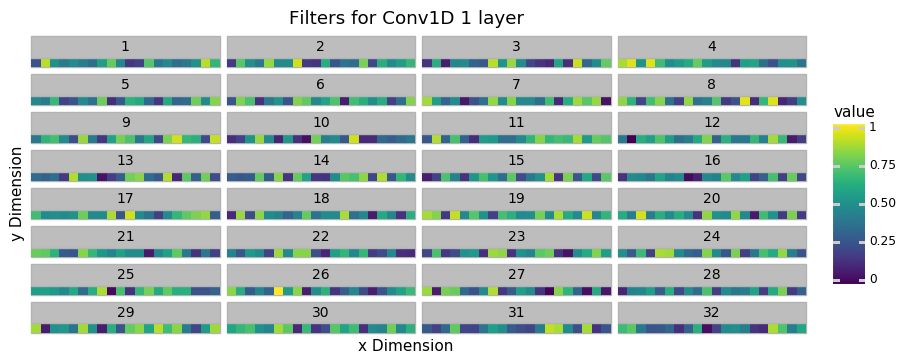

<ggplot: (7594981085)>

In [9]:
plot_filters(conv1d_1_df, "Conv1D 1")

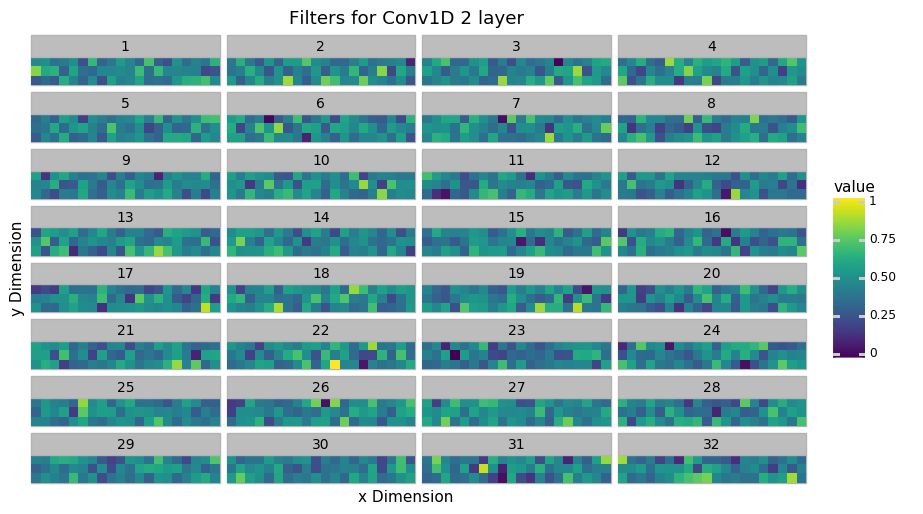

<ggplot: (7595875845)>

In [10]:
plot_filters(conv1d_2_df, "Conv1D 2")

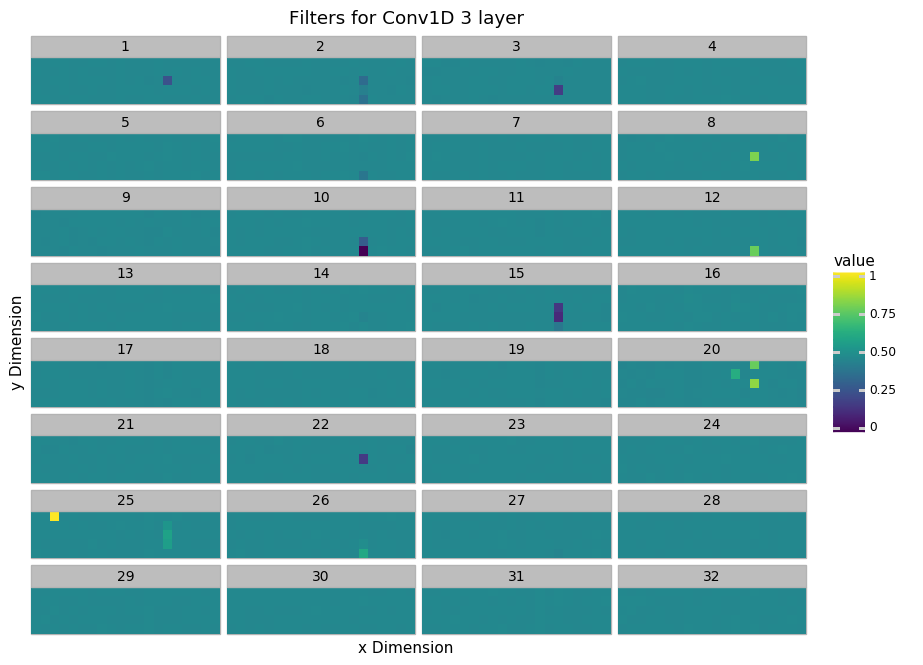

<ggplot: (7596793241)>

In [11]:
plot_filters(conv1d_3_df, "Conv1D 3")

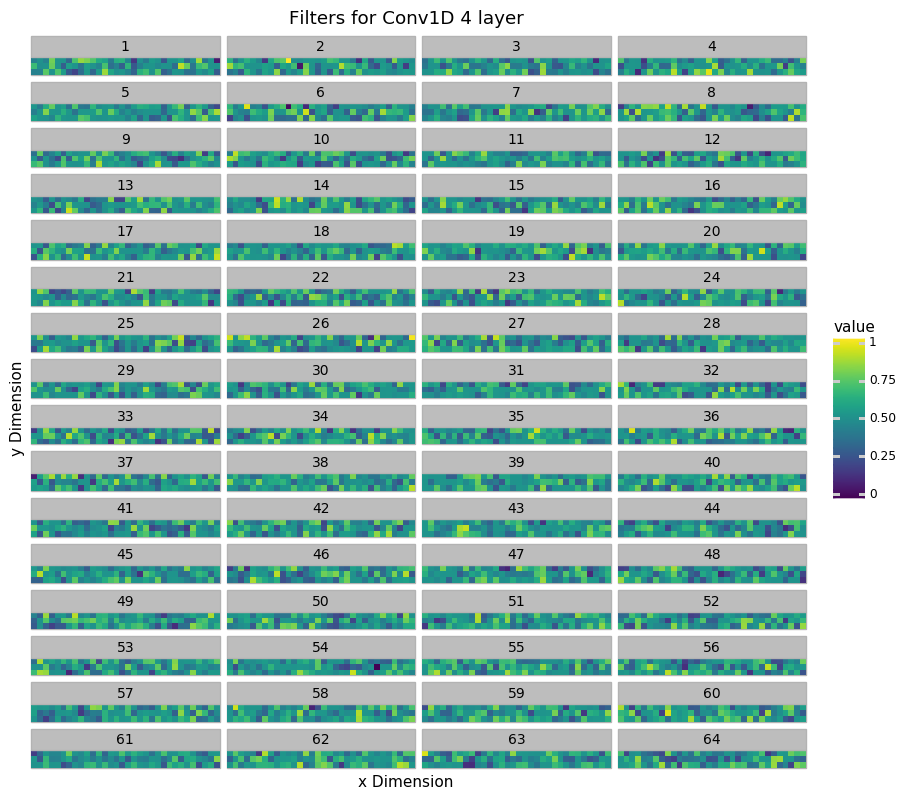

<ggplot: (7597840849)>

In [12]:
plot_filters(conv1d_4_df, "Conv1D 4")

# Visializing predictions

In [13]:
from tensorflow.keras.models import Model
from numpy import expand_dims

## Load data

In [15]:
# Get the reprocessed data from .npy file
x_train = np.load('../r-scripts/getting-data-current/data-sets/x_train.npy')
# y_train = np.load('data-sets/y_train.npy')

In [16]:
x_train.shape

(462, 4034, 20)

In [ ]:
# x_dev = np.load('../r-scripts/getting-data-current/data-sets/x_val.npy')
# y_dev = np.load('../r-scripts/getting-data-current/data-sets/y_val.npy')

In [ ]:
# x_test = np.load('../r-scripts/getting-data-current/data-sets/x_test.npy')
# y_test = np.load('../r-scripts/getting-data-current/data-sets/y_test.npy')

## Apply model and transform data into data frame

In [17]:
def get_partial_output_data(num_layer, num_data, seq_length, filters_to_display):
    # Get feature maps
    data_for_checking = x_train[range(num_data, num_data+1), :, :]
    
    model_partial = Model(inputs = model.inputs, outputs = model.layers[num_layer].output)
    feature_map = model_partial.predict(data_for_checking)
    feature_map = feature_map[:, :seq_length, :]
    
    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = feature_map.min(), feature_map.max()
    feature_map = (feature_map - f_min) / (f_max - f_min)
    
    # Limits for loop iterations
    num_x, num_y, num_filters = np.shape(feature_map)
    
    print(np.shape(feature_map))

    # Create data frame
    feature_map_df = pd.DataFrame({
        "y" : [], 
        "filter_num" : [], 
        "value" : []
    })
    
    # Loop to save filters data into df
    for y in range(num_y):
        for filt in range(num_filters):
            feature_map_df.loc[len(feature_map_df)] = np.array([y + 1, filt + 1, feature_map[0, y, filt]])
                
    # Make x, y, filter columns integers
    feature_map_df = (
        feature_map_df
        .astype({
            "y": "int64",
            "filter_num": "int64"
        })
        .query("filter_num in @filters_to_display")
    )
    
    return(feature_map_df)

## Visualize layers outpus

In [18]:
def plot_layer_outputs(conv_df, conv_title):
    outputs_fig = (
        ggplot(conv_df) +
        aes(y = "y", x = "filter_num", fill = "value") +
        geom_tile() +
        scale_x_continuous(expand = [0,0,0,0], breaks = np.arange(0, 100, 1)) +
        # scale_x_continuous(expand = [0,0,0,0], breaks = None) +
        scale_y_continuous(expand = [0,0,0,0], breaks = np.arange(0, 4034, 1)) +
        # scale_fill_manual(limits = [0,1]) +
        coord_fixed() +
        labs(
            title = "Outputs for " + conv_title + " layer",
            x = "Filter",
            y = "Sequence length"
        ) +
        theme_light() +
        theme(
            figure_size = [10,6],
            panel_grid_major = element_blank(),
            panel_grid_minor = element_blank(),
            strip_text = element_text(colour = 'black', size = 10),
            strip_background = element_rect(colour = None, fill = "#BDBDBD")
        )
    )
    
    return(outputs_fig)

## Run functions

In [40]:
feature_map_conv_layer1 = get_partial_output_data(
    num_layer = 1, 
    num_data = 10, 
    seq_length = 50, 
    filters_to_display = range(1, 32 + 1) # +1 so the last one can be shown
)

(1, 50, 32)


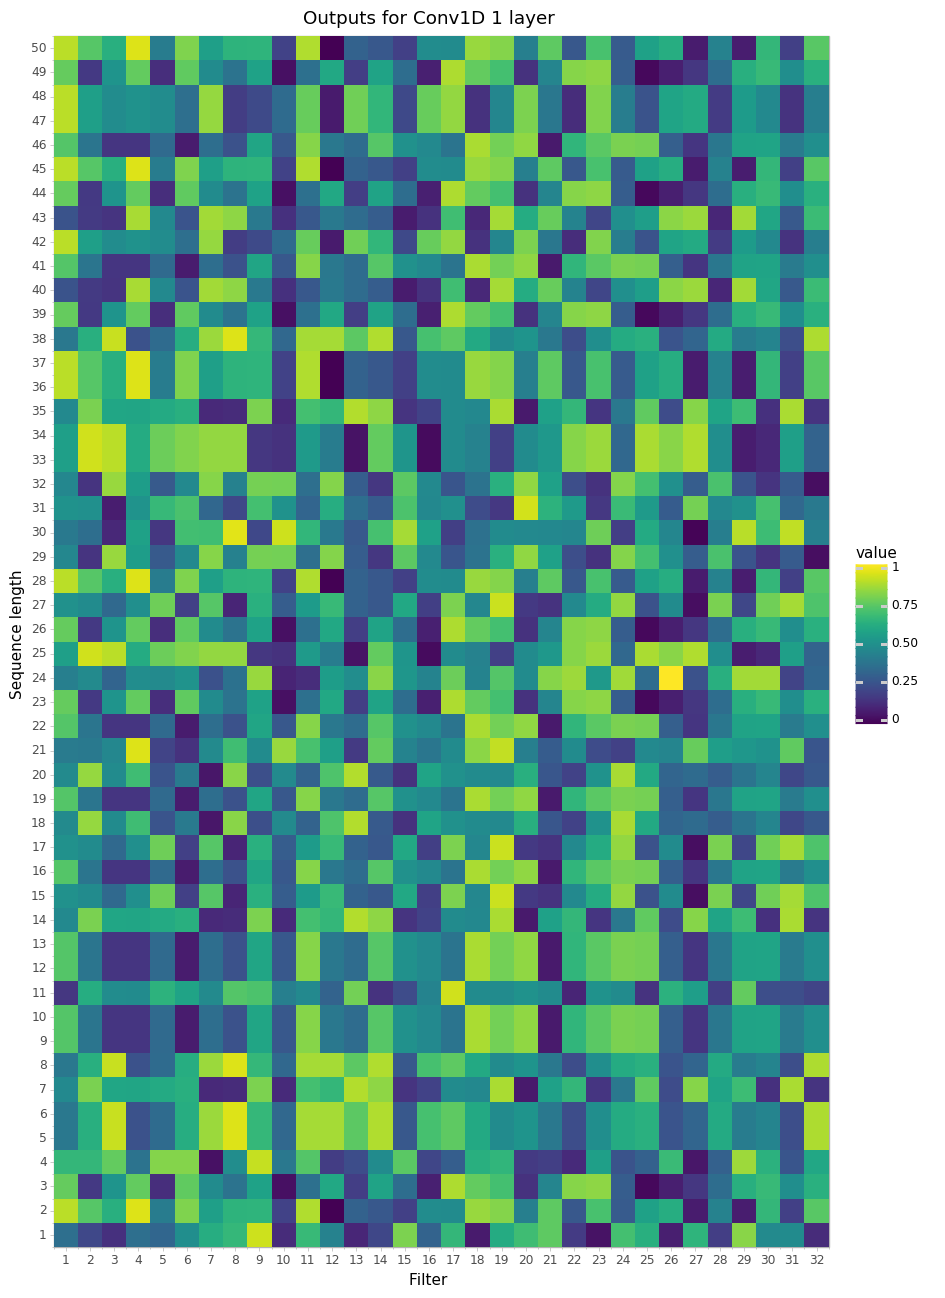

<ggplot: (7595500185)>

In [41]:
plot_layer_outputs(feature_map_conv_layer1, "Conv1D 1")

In [28]:
feature_map_conv_layer2 = get_partial_output_data(
    num_layer = 2, 
    num_data = 10, 
    seq_length = 25, 
    filters_to_display = range(1, 32 + 1) # +1 so the last one can be shown
)

(1, 25, 32)


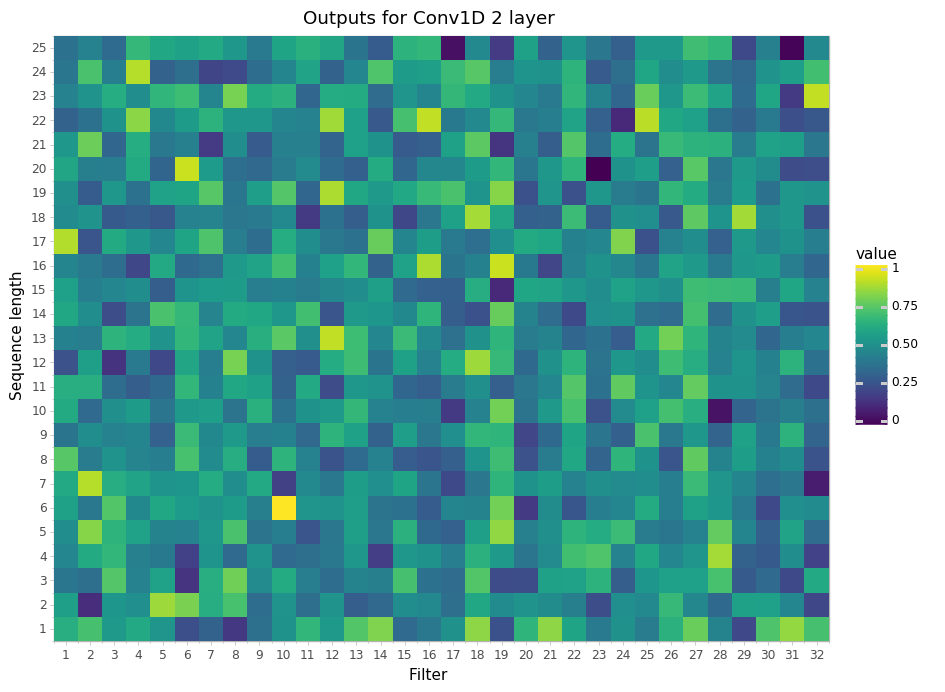

<ggplot: (7621310793)>

In [29]:
plot_layer_outputs(feature_map_conv_layer2, "Conv1D 2")

In [26]:
feature_map_conv_layer3 = get_partial_output_data(
    num_layer = 3, 
    num_data = 10, 
    seq_length = 25, 
    filters_to_display = range(1, 32 + 1) # +1 so the last one can be shown
)

(1, 25, 32)


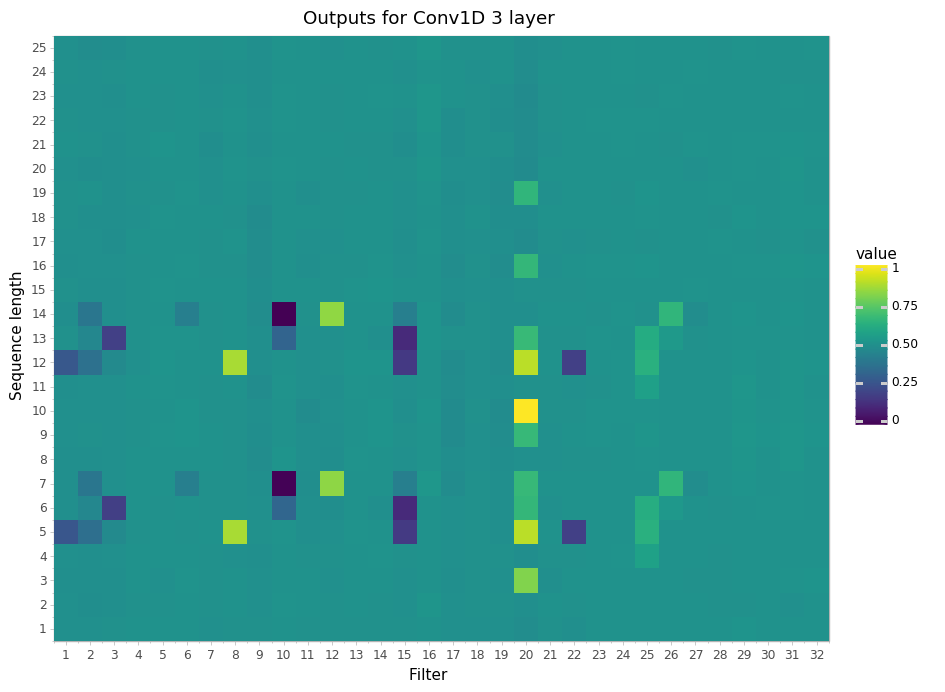

<ggplot: (7620715053)>

In [27]:
plot_layer_outputs(feature_map_conv_layer3, "Conv1D 3")

In [24]:
# Getting the visualisation from Conv1d_4  
feature_map_concatenation = get_partial_output_data(
    num_layer = 10, 
    num_data = 10, 
    seq_length = 20, 
    filters_to_display = range(1, 32 + 1) # +1 so the last one can be shown
)

(1, 20, 32)


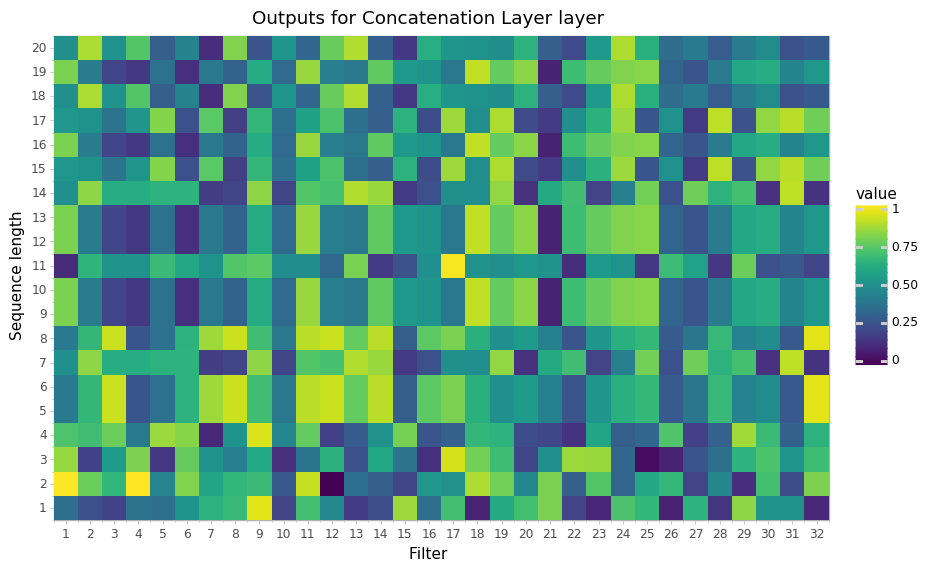

<ggplot: (7620485853)>

In [25]:
plot_layer_outputs(feature_map_concatenation, "Concatenation Layer")

In [36]:
# Getting the visualisation from Conv1d_4  
feature_map_conv_layer11 = get_partial_output_data(
    num_layer = 11, 
    num_data = 10, 
    seq_length = 100, 
    filters_to_display = range(1, 64 + 1) # +1 so the last one can be shown
)

(1, 100, 64)


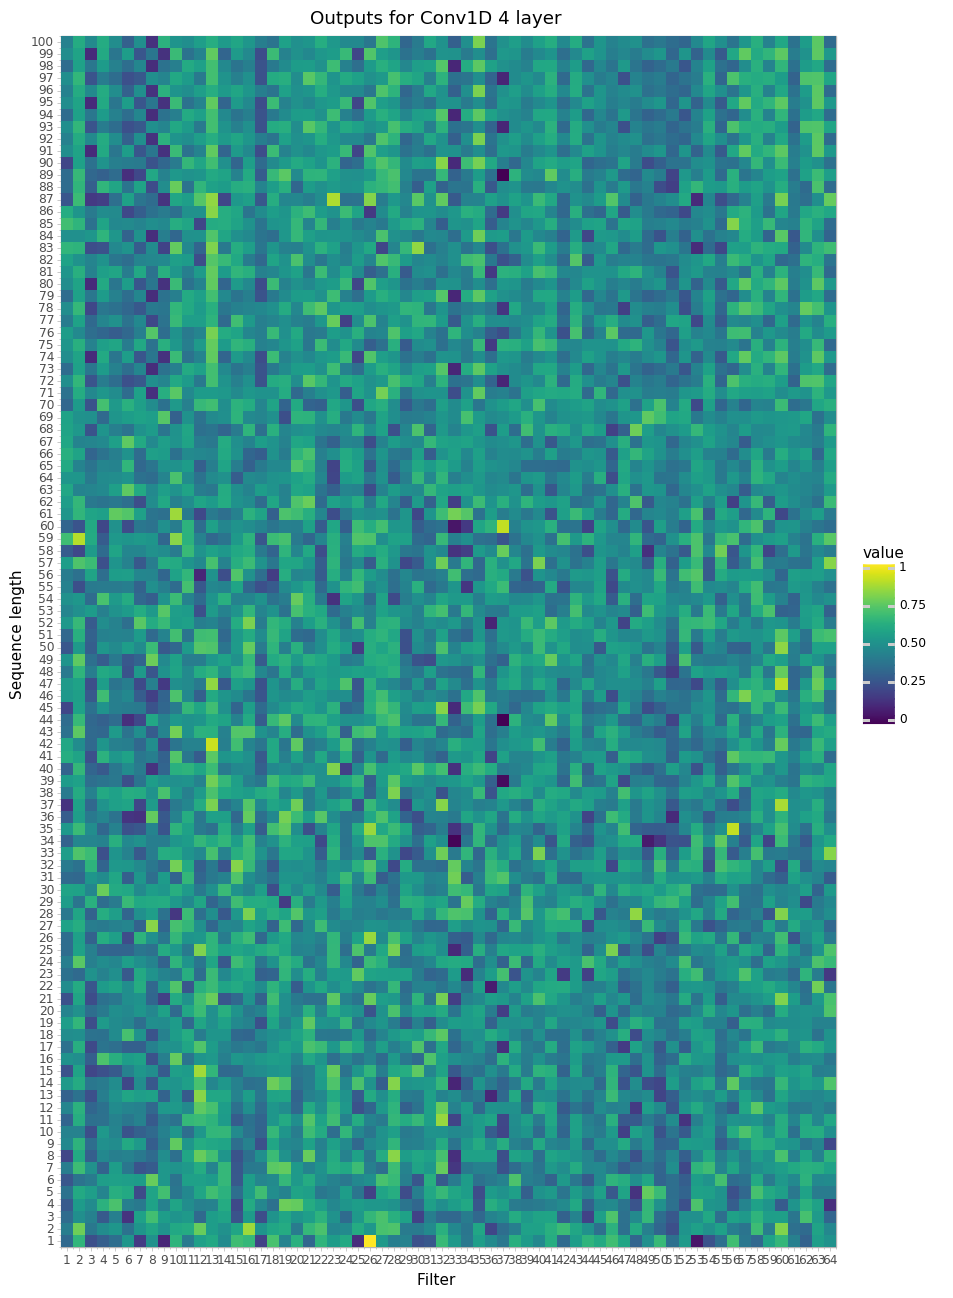

<ggplot: (7593828777)>

In [37]:
plot_layer_outputs(feature_map_conv_layer11, "Conv1D 4")